# Term project - MNIST visualization<br>
Deep neural network 구현 및 Visualization과 이를 통한 Neural network에 대한 이해 향상


## MNIST dataset 불러 오기 및 시각화

1. data에 대한 pca(2d라? 겹치는 경유 확인가능) + tsne결과 확인하기
    둘의 차이 확인하기
2. layer들의 dimension 확인

• Input image에 대한 PCA, t-SNE 결과
• hidden vector (a[0], z[1], a[1], z[2], a[2])에 대한 PCA, ,t-SNE결과
    ->  총 10장
• 결과 분석 (자유롭게)


In [1]:
from __future__ import print_function

import torch
from torch import nn
from torch import optim
import numpy as np

import time

# dataset
import torchvision 
from torchvision import datasets
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# sklearn
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



%matplotlib inline

## Hyperparameter
modeling 과정에서 직접 설정하는 값입니다.<br>
- batch_size
- learning rate : 학습률(gradient를 통해 weight를 이동, 변화시키는 정도)
- epoch_nums : 학습을 반복하는 횟수
- batch size : 한번의 batch마다 주어지는 data sample의 size (batch: 나누어진 dataset)
- momentum : weight의 update과정에서 관성, 가속도를 주어 감소, 증가하는 방향으로 더 많은 변화를 준다.

In [2]:
batch_size = 12
learning_rate = 0.01
epoch_num = 10

## MNIST dataset
### torchvision.datasets.MNIST = (root="", train="", dawnload="",trasform ="")
root = "data의 경로" <br>
train = True(학습용 데이터) or False(test용 데이터) <br>
tramsform - 데이터 형태 <br>
download = True(MNIST dataset이 없으면 다운로드한다.) <br>

In [3]:
train_data = datasets.MNIST(root= '..\datasets', train= True, download= True, transform= transforms.ToTensor())
test_data = datasets.MNIST(root= '..\datasets', train= False, download= True, transform= transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

D:\develop\Anaconda\envs\ai21\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Deep Neural Network
## input layer와 ouput layer사이에 hidden layer를 2개이상 지닌 neural network을 의미합니다.
분류와 수치예측을 주목적으로 하여 이미지 학습과 문자인식에 유용하게 사용되고 있는 신경망입니다.

## Using squential 
squential하여 내부  module에 접급하지 않는다.

In [11]:
class DeepNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.in_dim = 28 * 28 # MNIST
        self.out_dim = 10 # 0 ~ 9
        
        self.model = nn.Sequential(
            nn.Linear(in_features = self.in_dim, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = self.out_dim)
        )

    def forward(self, x):
        return self.model(x.view(-1, self.in_dim))



## Train

In [12]:
model = DeepNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(epoch_num):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs: data is a list of [input, label]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward, backward, optimizer
        outputs = model(inputs)
        
        loss = criterion(outputs, labels) # loss
        loss.backward() # backward
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0 : # print every 2000 mini-batch
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss/2000) )
            running_loss = 0.0
print("Finished training")

[1,  2000] loss: 2.176
[1,  4000] loss: 0.680
[2,  2000] loss: 0.296
[2,  4000] loss: 0.222
[3,  2000] loss: 0.162
[3,  4000] loss: 0.142
[4,  2000] loss: 0.113
[4,  4000] loss: 0.105
[5,  2000] loss: 0.081
[5,  4000] loss: 0.083
[6,  2000] loss: 0.060
[6,  4000] loss: 0.067
[7,  2000] loss: 0.047
[7,  4000] loss: 0.051
[8,  2000] loss: 0.036
[8,  4000] loss: 0.043
[9,  2000] loss: 0.030
[9,  4000] loss: 0.031
[10,  2000] loss: 0.025
[10,  4000] loss: 0.024
Finished training


## Using ModuleList
Module을 리스트 형태로 담을 때 사용합니다. ModuleList에서는 module하나하나에 접근이 가능하다.

In [15]:
# Using ModuleList
class DeepNN_ML(nn.Module):
    def __init__(self):
        super(DeepNN_ML, self).__init__()

        self.in_dim = 28 * 28 # MNIST
        self.out_dim = 10 # 0 ~ 9
        sizes = [[self.in_dim, 512], [512, 256],[256, 128],[128,64]]
        
        self.list = nn.ModuleList([
            nn.Linear(in_features = self.in_dim, out_features = 512),
            nn.ReLU(),
            nn.Linear(in_features = 512, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 128),
            nn.ReLU(),
            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(),
            nn.Linear(in_features = 64, out_features = self.out_dim)
        ])

    def forward(self, x):
        fw = x.view(-1, self.in_dim)
        for module in self.list:
            fw = module(fw)
        return fw



In [17]:
model_ML = DeepNN_ML()
criterion_ML = nn.CrossEntropyLoss()
optimizer_ML = optim.SGD(model_ML.parameters(), lr = learning_rate)

for epoch in range(epoch_num):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs: data is a list of [input, label]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_ML.zero_grad()

        # forward, backward, optimizer
        outputs = model_ML(inputs)
        
        loss = criterion_ML(outputs, labels) # loss
        loss.backward() # backward
        optimizer_ML.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 2000 == 0 : # print every 2000 mini-batch
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss/2000) )
            running_loss = 0.0
print("Finished training")

[1,  2000] loss: 2.102
[1,  4000] loss: 0.658
[2,  2000] loss: 0.295
[2,  4000] loss: 0.227
[3,  2000] loss: 0.151
[3,  4000] loss: 0.135
[4,  2000] loss: 0.105
[4,  4000] loss: 0.098
[5,  2000] loss: 0.079
[5,  4000] loss: 0.075
[6,  2000] loss: 0.057
[6,  4000] loss: 0.062
[7,  2000] loss: 0.046
[7,  4000] loss: 0.049
[8,  2000] loss: 0.038
[8,  4000] loss: 0.039
[9,  2000] loss: 0.028
[9,  4000] loss: 0.032
[10,  2000] loss: 0.024
[10,  4000] loss: 0.024
Finished training


## Test

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

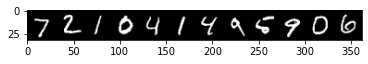

Ground truth
   7   2   1   0   4   1   4   9   5   9   0   6
Predicted
   7   2   1   0   4   1   4   9   6   9   0   6


In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow = batch_size))
print('Ground truth')
print(" "+" ".join("%3s" % label.item() for label in labels))

outputs = model(images)
_, pred = torch.max(outputs, 1)
print("Predicted")
print(" "+" ".join("%3s" % label.item() for label in pred))